In [ ]:
pip install pmdarima

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
data_store = pd.read_csv('/content/drive/MyDrive/Virtual Internship Kalbe Nutritionals X Rakamin Academy/Dataset/Case Study - Store.csv', sep= ';')
data_product = pd.read_csv('/content/drive/MyDrive/Virtual Internship Kalbe Nutritionals X Rakamin Academy/Dataset/Case Study - Product.csv', sep= ';')
data_customer = pd.read_csv('/content/drive/MyDrive/Virtual Internship Kalbe Nutritionals X Rakamin Academy/Dataset/Case Study - Customer.csv', sep= ';')
data_transaction = pd.read_csv('/content/drive/MyDrive/Virtual Internship Kalbe Nutritionals X Rakamin Academy/Dataset/Case Study - Transaction.csv', sep= ';')

In [4]:
#merge all data
merge1 = pd.merge(data_transaction, data_customer, on = 'CustomerID', how = 'inner')
merge2 = pd.merge(merge1, data_store, on = 'StoreID', how = 'inner')
data_merged = pd.merge(merge2, data_product, on = 'ProductID', how = 'inner')
data_merged.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,Price_y
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
1,TR89318,183,17/07/2022,P3,7500,1,7500,12,27,1,Single,"0,18",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
2,TR9106,123,26/09/2022,P3,7500,4,30000,12,34,0,Married,"4,36",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
3,TR4331,335,08/01/2022,P3,7500,3,22500,12,29,1,Single,"4,74",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
4,TR6445,181,10/01/2022,P3,7500,4,30000,12,33,1,Married,"9,94",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500


In [ ]:
data_merged.info()

In [6]:
# drop data yang tidak digunakan
data_merged.drop(
    columns =['Price_y','Latitude','Longitude'],
    inplace = True)

In [ ]:
data_merged.info()

In [ ]:
data_merged.isna().sum()

In [ ]:
data_merged.dropna(inplace = True)
data_merged.isna().sum()

In [ ]:
data_merged.info()

In [ ]:
# merubah tipe data Date 'object' menjadi 'Datetime'
data_merged['Date'] = pd.to_datetime(data_merged['Date'])
data_merged.head()

# Machine Learning Time Series ARIMA

In [12]:
# preparation data yang akan di regresi
data_totalquantity = data_merged.groupby('Date').agg({'Qty':'sum'})
data_totalquantity

,Qty
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


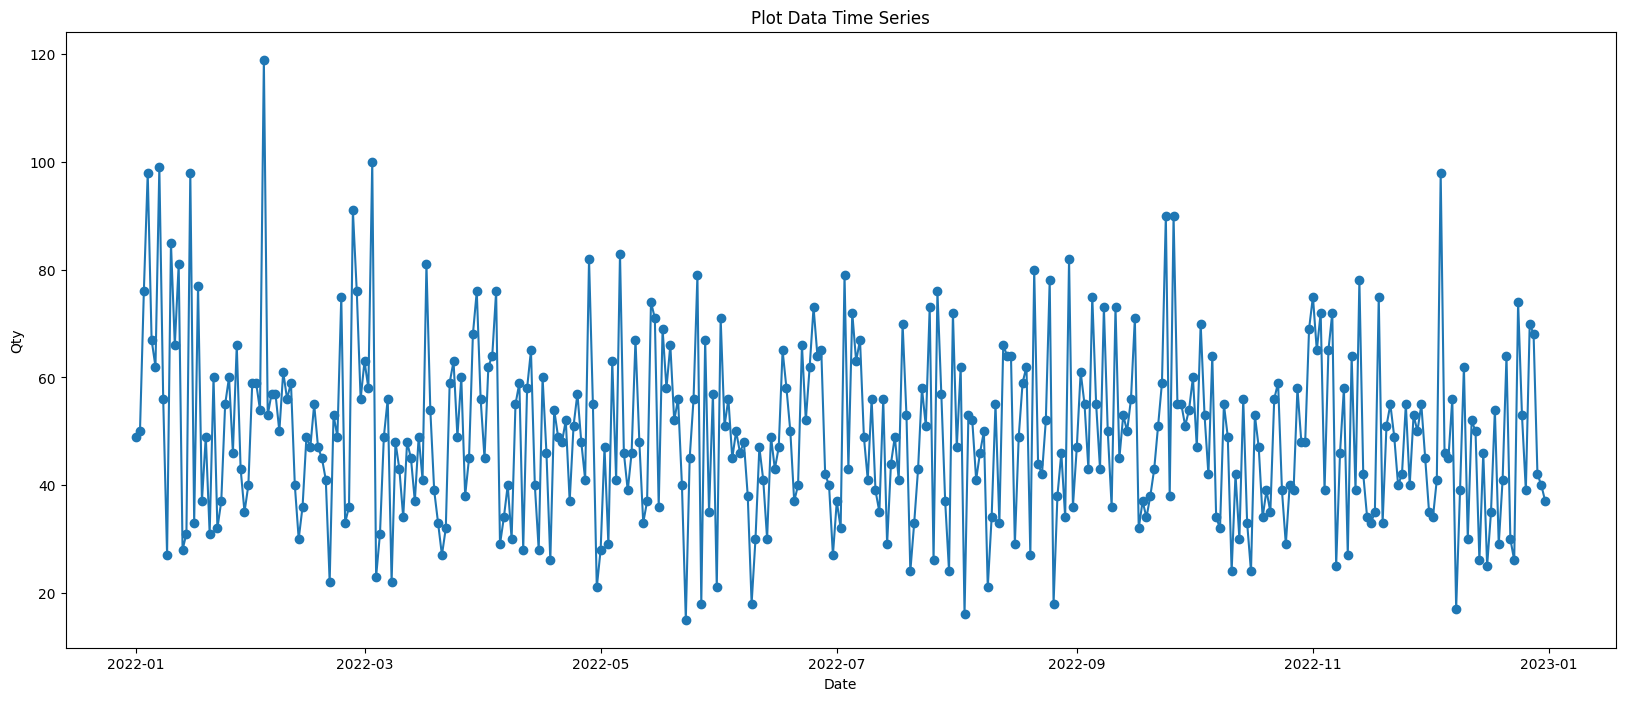

In [55]:
plt.figure(figsize=(20,8))
plt.plot(data_totalquantity['Qty'], marker = 'o')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Plot Data Time Series')
plt.show()

In [123]:
# Split Data Train dan Data Test
print(data_totalquantity.shape)
test_size = round(data_totalquantity.shape[0] * 0.15)

data_train = data_totalquantity.iloc[:-1*(test_size)]
data_test = data_totalquantity.iloc[-1*(test_size):]
print(data_train.shape, data_test.shape)

(365, 1)
(310, 1) (55, 1)


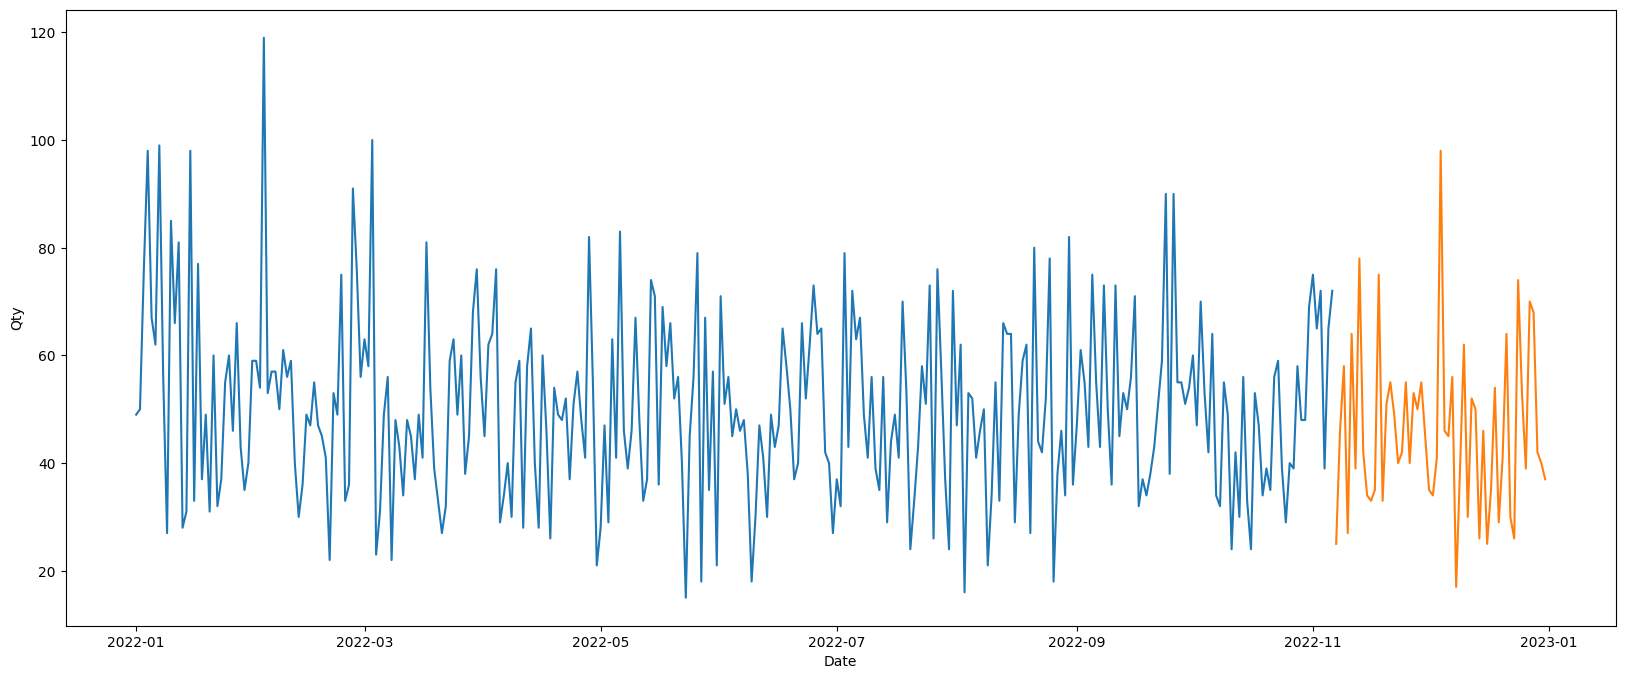

In [57]:
plt.figure(figsize=(20,8))
sns.lineplot(data=data_train, x=data_train.index, y=data_train['Qty'])
sns.lineplot(data=data_test, x=data_test.index, y=data_test['Qty'])
plt.show()

In [122]:
data_train.tail()

,Qty
Date,
2022-11-02,65
2022-11-03,72
2022-11-04,39
2022-11-05,65
2022-11-06,72


In [121]:
data_test.tail()

,Qty
Date,
2022-12-27,70
2022-12-28,68
2022-12-29,42
2022-12-30,40
2022-12-31,37


In [124]:
from statsmodels.tsa.stattools import adfuller

# melakukan tes stasioneritas Augmented Dickey-Fuller (ADF) pada data time series.
# membuat fungsi ADF untuk menguji apakah data time series stasioner atau tidak.
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

adf_test(data_totalquantity)

1. ADF :  -19.091513872408132
2. P-Value :  0.0
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 364
5. Critical Values :
	 1% :  -3.4484434475193777
	 5% :  -2.869513170510808
	 10% :  -2.571017574266393


P-Value < 0,05 sehingga data stationery dapat digunakan dalam analisis time series dengan ARIMA. Dan data time series merupakan **stasioner**.

In [130]:
model_arima = pm.auto_arima(data_train, stepwise=False, seasonal=False)
model_arima

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [135]:
model = ARIMA(data_test, order=(1,0,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=31)

In [136]:
data_totalquantity

,Qty
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


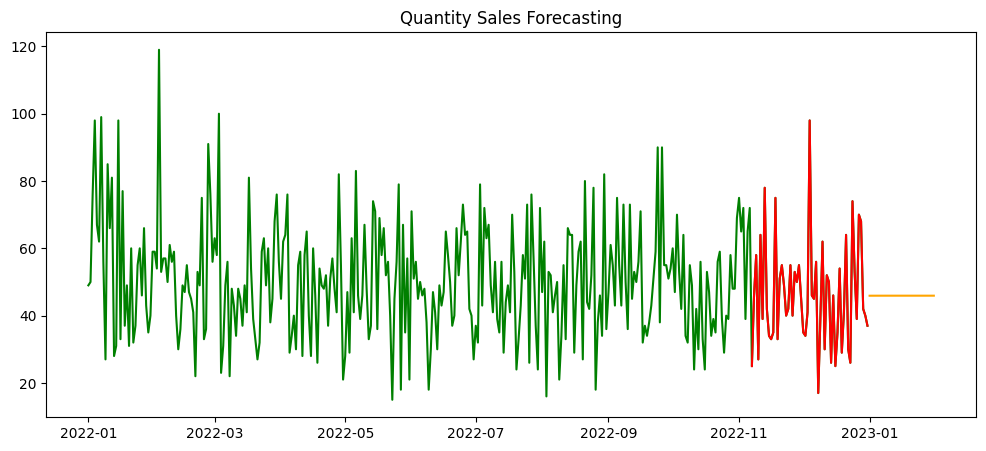

In [147]:
plt.figure(figsize=(12,5))
plt.plot(data_totalquantity, color='green')
plt.plot(data_test, color='red')
plt.plot(forecast,color='orange')
plt.title('Quantity Sales Forecasting')
plt.show()

In [134]:
forecast.describe()

count    31.000000
mean     45.929789
std       0.003150
min      45.919165
25%      45.929620
50%      45.931331
75%      45.931605
max      45.931650
Name: predicted_mean, dtype: float64

Berdasarkan insight yang didapat, perkiraan prediksi total quantity harian berdasarkan produk yang terjual berkisar 45-46 pcs/hari.

In [154]:
# prediksi pada Januari 2023
forecast_length = 31
forecast_result = model_fit.get_forecast(forecast_length)
forecast_result_arima = forecast_result.conf_int()
forecast_result_arima['forecasted Qty'] = model_fit.predict(start = forecast_result_arima.index[0],
                                                      end = forecast_result_arima.index[-1])
forecast_result_arima['Date'] = pd.date_range(start = '2023-01-01', end = '2023-01-31')
forecast_result_arima.set_index('Date', inplace = True)
forecast_result_arima

,lower Qty,upper Qty,forecasted Qty
Date,,,
2023-01-01,17.164792,74.673537,45.919165
2023-01-02,16.601672,75.242042,45.921857
2023-01-03,16.260946,75.586994,45.923970
2023-01-04,16.053574,75.797680,45.925627
2023-01-05,15.926961,75.926893,45.926927
2023-01-06,15.849532,76.006361,45.927947
2023-01-07,15.802157,76.055336,45.928747
2023-01-08,15.773175,76.085573,45.929374
2023-01-09,15.755460,76.104273,45.929866


# Machine Learning Clustering Customer

In [164]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [200]:
data_merged.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Product Name
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,Crackers
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,"0,18",Prestasi Utama,Prestasi,General Trade,Crackers
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,"4,36",Prestasi Utama,Prestasi,General Trade,Crackers
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,"4,74",Prestasi Utama,Prestasi,General Trade,Crackers
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,"9,94",Prestasi Utama,Prestasi,General Trade,Crackers


In [201]:
df_cluster = data_merged.groupby('CustomerID').agg({'TransactionID':'count',
                                                   'Qty':'sum',
                                                   'TotalAmount':'sum'}).reset_index()
df_cluster

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
439,442,13,37,269400
440,444,18,62,577700
441,445,18,68,587200
442,446,11,42,423300


In [202]:
x = df_cluster.drop(columns = ['CustomerID'])
x

,TransactionID,Qty,TotalAmount
0,17,60,623300
1,13,57,392300
2,15,56,446200
3,10,46,302500
4,7,27,268600
...,...,...,...
439,13,37,269400
440,18,62,577700
441,18,68,587200
442,11,42,423300


In [203]:
sc = StandardScaler()
x_sc = sc.fit_transform(x)
x_sc

array([[ 1.78828224,  1.50893374,  2.10242393],
       [ 0.55344971,  1.27289149,  0.24634281],
       [ 1.17086598,  1.19421074,  0.67942841],
       ...,
       [ 2.09699037,  2.13837973,  1.81236104],
       [-0.06396655,  0.09268025,  0.49542729],
       [ 0.55344971,  0.09268025,  0.62398702]])

In [204]:
wcss= []
for n in range (1,11):
    model = KMeans(n_clusters=n, init='k-means++', random_state = 42)
    model.fit(x_sc)
    wcss.append(model.inertia_)
print(wcss)

[1332.0000000000005, 543.4711248616254, 316.55344988206673, 237.6926072959066, 191.11956602309158, 169.66881283944178, 154.4254584347139, 140.0807499402461, 131.2808883140645, 120.88324686717107]


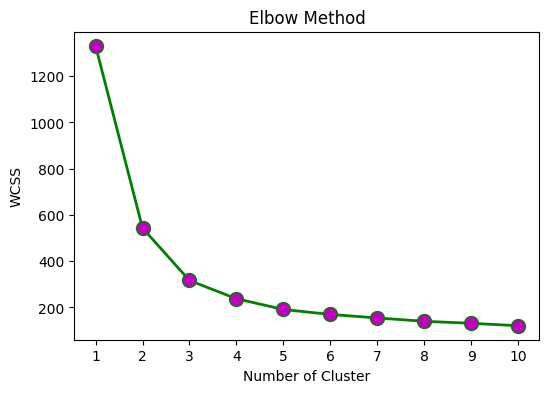

In [205]:
plt.figure(figsize=(6,4))
plt.plot(list(range(1,11)), wcss, color = 'g', marker = 'o', linewidth=2, markersize=10, markerfacecolor= 'm')
plt.title('Elbow Method')
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS')
plt.xticks(list(range(1,11)))
plt.show()

In [206]:
kmeans_clust = KMeans(n_clusters=3,init='k-means++',random_state=42)
kmeans_clust.fit(x_sc)

df_cluster['Cluster'] = kmeans_clust.labels_
df_cluster.head()

,CustomerID,TransactionID,Qty,TotalAmount,Cluster
0,1,17,60,623300,2
1,2,13,57,392300,2
2,3,15,56,446200,2
3,4,10,46,302500,1
4,5,7,27,268600,0


<Figure size 600x600 with 0 Axes>

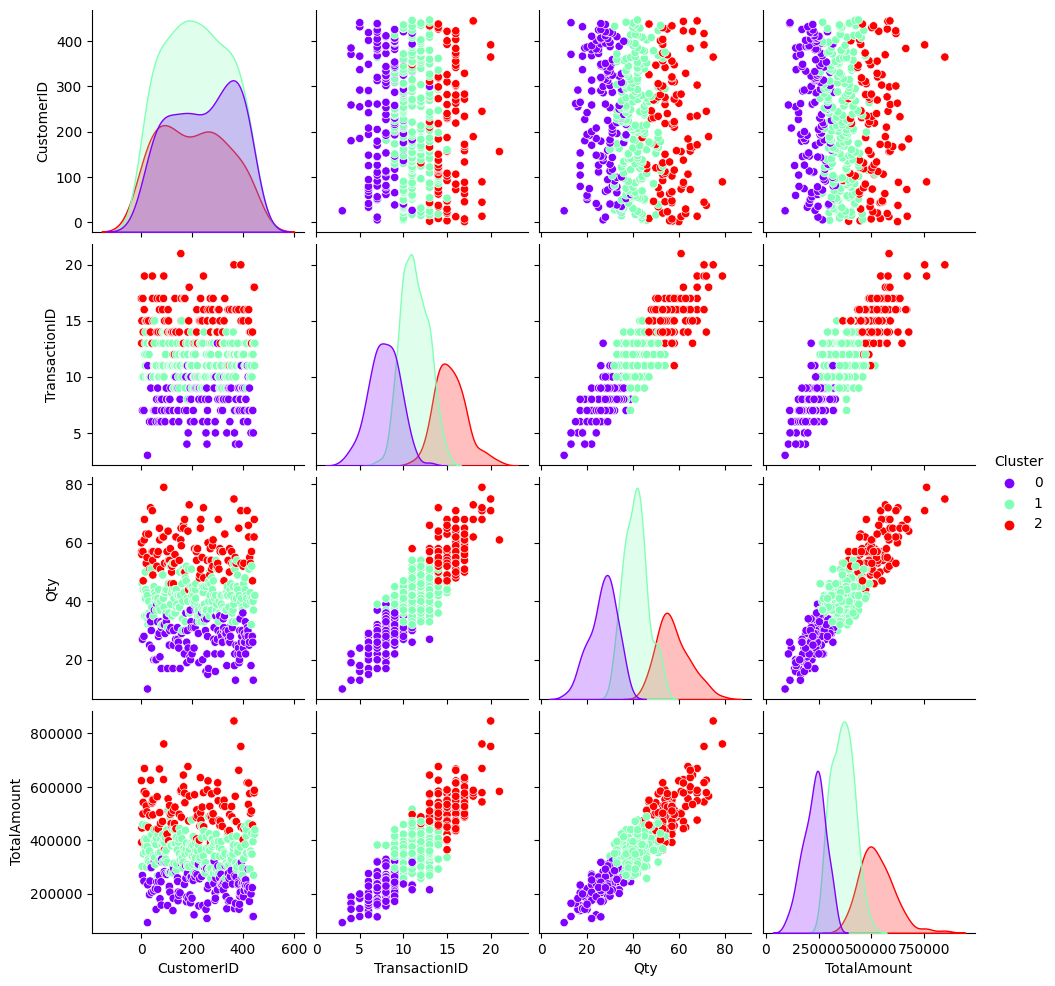

In [207]:
plt.figure(figsize=(6,6))
sns.pairplot(data=df_cluster,hue='Cluster',palette='rainbow')
plt.show()

In [221]:
df_fix = df_cluster.drop(columns = ['CustomerID'])
df_fix.groupby('Cluster').agg(['min', 'max','count','mean', 'median'])

TransactionID                             Qty                       \
                  min max count       mean median min max count       mean   
Cluster                                                                      
0                   3  13   135   7.785185    8.0  10  39   135  26.933333   
1                   7  15   202  11.282178   11.0  30  54   202  41.188119   
2                  11  21   107  15.383178   15.0  44  79   107  57.654206   

               TotalAmount                                         
        median         min     max count           mean    median  
Cluster                                                            
0         28.0       92100  329300   135  229388.888889  235300.0  
1         41.0      257600  516600   202  363267.326733  362400.0  
2         57.0      365000  846700   107  525431.775701  512400.0

In [222]:
# percentage of customers per cluster
cluster_count = df_cluster['Cluster'].value_counts().reset_index()
cluster_count.columns = ['Cluster', 'count']
cluster_count['percentage (%)'] = round((cluster_count['count']/len(df_cluster))*100,2)
cluster_count = cluster_count.sort_values(by = ['Cluster']).reset_index(drop = True)
cluster_count

,Cluster,count,percentage (%)
0,0,135,30.41
1,1,202,45.50
2,2,107,24.10


In [219]:
data_cluster = df_cluster[['CustomerID','Cluster']]
data_cluster.head(10)

,CustomerID,Cluster
0,1,2
1,2,2
2,3,2
3,4,1
4,5,0
5,6,1
6,7,2
7,8,2
8,9,1
9,11,0


In [220]:
# Kelompokkan data berdasarkan kolom "cluster"
grouped = data_cluster.groupby('Cluster')

# Iterasi melalui setiap klaster dan menampilkannya
for key, group in grouped:
    print(f'Cluster {key}:')
    print(group)
    print('\n')

Cluster 0:
     CustomerID  Cluster
4             5        0
9            11        0
23           25        0
24           26        0
31           33        0
..          ...      ...
423         426        0
429         432        0
434         437        0
436         439        0
438         441        0

[135 rows x 2 columns]


Cluster 1:
     CustomerID  Cluster
3             4        1
5             6        1
8             9        1
12           14        1
13           15        1
..          ...      ...
433         436        1
437         440        1
439         442        1
442         446        1
443         447        1

[202 rows x 2 columns]


Cluster 2:
     CustomerID  Cluster
0             1        2
1             2        2
2             3        2
6             7        2
7             8        2
..          ...      ...
427         430        2
431         434        2
435         438        2
440         444        2
441         445        2

[107 rows x 2 

# Insight :
**Cluster 0** :
- Memiliki **jumlah penjualan produk paling sedikit**, tetapi **cukup banyak yang melakukan transaksi**, kemungkinan jumlah produk yang dibeli sedikit tetapi banyak jenis produk.

**Rekomendasi** :
- Membuat bundle produk, seperti beli 3 gratis 1, atau membuat paket produk dan sebagainya.
---
**Cluster 1** :
- Memiliki **jumlah penjualan produk cukup banyak**, dan **paling banyak melakukan transaksi**, kemungkinan jumlah produk dan jenis produk yang dibeli proporsional. Situasi ini dapat dikatakan positif.

**Rekomendasi** :
- Mempertahankan situasi atau,
- Cross-Selling dan Upselling: teknik penjualan seperti cross-selling (menawarkan produk tambahan yang relevan) dan upselling (menawarkan produk yang lebih canggih atau mahal) untuk meningkatkan nilai keranjang belanja.
---
**Cluster 2** :
- Memiliki **jumlah penjualan paling banyak**, tetapi **jumlah transaksi paling sedikit**, kemungkinan jumlah produk yang dibeli banyak tetapi hanya beberapa jenis produk.

**Rekomendasi** :
- Rekomendasi Produk: untuk menampilkan produk yang relevan atau sering dibeli bersama produk-produk populer. Ini dapat mendorong pelanggan untuk mengeksplorasi produk lain dalam kategori yang sama.